In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate #base 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, roc_auc_score, log_loss, roc_curve, auc
import glob,os,random
import mlflow
from mlflow.models import infer_signature
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import tqdm,os
import datetime
import time
from joblib import Parallel, delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV



# Proceso:
--------------------------------
   1. Cargo data Conglomerada(Carga distribuida en hilos
   2. Limpiar conglomerado
   2. Analisis exploratorio
   3. Balancer Datos
   4. PIPELINE
        5. Aplicar encoder para las columnas categoricas
   7. Dividar en train y test y Entrenar modelo
   8. Dummy Clasifier 
   10. Iniciar MLFlow para capturar metricas
   14. Prueba con data Real
   15. Serializacion del Modelo

# 1. Cargo data Conglomerada(Carga distribuida en hilos)


In [27]:
import pandas as pd
import os
import time
import datetime
from joblib import Parallel, delayed
import tqdm

## SOLICITANTE = 'Eduardo Iberico'
def process_file(file_path):
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    df = df[df.SOLICITANTE == 'Eduardo Iberico']
    df['DATE'] = datetime.datetime.fromtimestamp(os.path.getctime(file_path))
    return df
    
start_time = time.time()
# Ruta al directorio que contiene los archivos
directorio = r'C:\Users\C26764\America Movil Peru S.A.C\EAS - 1'
file_paths = [os.path.join(directorio, filename) for filename in os.listdir(directorio)
              if os.path.isfile(os.path.join(directorio, filename)) and filename.endswith(('.xlsx'))] ## Creo lista de rutas a iterar 

# Esto crea la lista de rutas a iterar solo para archivos Excel

# Uso de Parallel y delayed para procesamiento paralelo
results = Parallel(n_jobs=-1)(delayed(process_file)(file_path) for file_path in tqdm.tqdm(file_paths)) ## Paraleliso el proceso

# Combina todos los DataFrames
df_combinado_EA = pd.concat(results, ignore_index=True)
end_time = time.time()

# Calcula el tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:26<00:00,  1.38it/s]


Tiempo de ejecución: 44.77326440811157 segundos


# 2. Limpio Data 

In [28]:
df_combinado_EA = df_combinado_EA.sort_values(by='DATE',ascending=True)

In [29]:
df_combinado_EA.DATE = df_combinado_EA.DATE.dt.date

In [30]:
EA_dataset = df_combinado_EA.drop_duplicates(subset='CONCATENADO',keep='last')

In [31]:
EA_dataset.loc[:,'RESPONSABLE_DE_EA'] = EA_dataset.RESPONSABLE_DE_EA.combine_first(EA_dataset['RESPONSABLE DE EA']).combine_first(EA_dataset['RESPONSABLE EA'])

In [32]:
EA_dataset.to_csv(r"D:\Scripts1\sklrn\Data\RAW\Data_EAs.csv",index=False)

In [17]:
EA_dataset_cut = EA_dataset[['TEXTO','PROVEEDOR','NOMBRE PROYECTO','TIPO_PROYECTOS','CLASIF_FINANZAS',
                                               'CLASIF_RED_1','CLASIF_RED_2','RESPONSABLE_DE_EA']].dropna(subset='RESPONSABLE_DE_EA')
EA_dataset_cut_4Prep = EA_dataset[['TEXTO','PROVEEDOR','NOMBRE PROYECTO','TIPO_PROYECTOS','CLASIF_FINANZAS','SITE','CONCATENADO',
                                               'CLASIF_RED_1','CLASIF_RED_2','RESPONSABLE_DE_EA']].dropna(subset='CONCATENADO')
analistas_map = {'JENNY PIZAN':'JENNY',
                 'DANNER YARLEQUE':'DANNER',
                 'LAURA RAFAEL':'LAURA',
                 'ANNGIE':'ANGGIE'}
### Normalizo columna Tarjet 
EA_dataset_cut.loc[:,'RESPONSABLE_DE_EA'] = EA_dataset_cut.loc[:,'RESPONSABLE_DE_EA'].str.upper()
EA_dataset_cut.loc[:,'RESPONSABLE_DE_EA'] = EA_dataset_cut.loc[:,'RESPONSABLE_DE_EA'].replace(analistas_map)

## Exporto data para la capa silver

In [27]:
EA_dataset_cut_4Prep.CONCATENADO = EA_dataset_cut_4Prep.CONCATENADO.astype("int64")

In [30]:
EA_dataset_cut_4Prep.to_csv(r"Data/SILVER/Data_EAs.csv",index=False)

In [15]:
EA_dataset_cut = EA_dataset_cut[EA_dataset_cut.RESPONSABLE_DE_EA != 'POR ASIGNAR']

In [16]:
EA_dataset_cut.RESPONSABLE_DE_EA.value_counts(dropna=False)

RESPONSABLE_DE_EA
ANGGIE      1253
DEMETRIO     779
JHORDAN      526
LAURA        262
JORGE        158
DANNER       119
JENNY         78
FERNANDO      41
Name: count, dtype: int64

In [26]:
x_df = EA_dataset_cut.drop(columns=['RESPONSABLE_DE_EA']) # dimensiones
y = EA_dataset_cut.RESPONSABLE_DE_EA## target
X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.2, random_state=42)
# Divide el dataset en conjuntos de entrenamiento y prueba

# Preprocces: 
- Defino el preprocess
- Defino el pipline
- paso los datos al pipeline ya estructurado
 

In [31]:
categorical_features = x_df.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
params = {
    'ccp_alpha': 0.01,
    'n_estimators': 100,  # Número de árboles en el bosque
    'criterion': 'gini',
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'min_weight_fraction_leaf': 0.0,
    'max_features':'sqrt',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap': True,  # Utilizar muestreo con reemplazo
    'oob_score': False,  # No calcular la puntuación fuera de bolsa
    'n_jobs': -1,  # Utilizar todos los núcleos disponibles
    'random_state': 5,
    'class_weight': 'balanced'
}
# Modelo base para la selección de características
base_model = RandomForestClassifier(**params)

# Definir el pipeline con SMOTE, selección de características y class_weight
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),  # Balanceo de datos con SMOTE
    ('feature_selection', SelectFromModel(base_model)),  # Selección de características, para eso necesito el modelo base 
    ('classifier',base_model)  # Balanceo de datos con class_weight
])



param_grid = {
    'classifier__ccp_alpha': [0.0, 0.01],
    'classifier__n_estimators': [50, 100],
    'classifier__criterion': ['gini','entropy'],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__min_weight_fraction_leaf': [0.0],
    'classifier__max_features': ['sqrt','log2'],
    'classifier__max_leaf_nodes': [None],
    'classifier__min_impurity_decrease': [0.0],
    'classifier__bootstrap': [True],
    'classifier__oob_score': [False],
    'classifier__n_jobs': [-1],  # Generalmente no se optimiza
    'classifier__random_state': [5],  # Generalmente no se optimiza
    'classifier__class_weight': ['balanced','balanced_subsample',None]
}



grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [57]:
best_model = grid_search.best_estimator_
best_model.score(X_test,y_test)

C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.9597806215722121

In [58]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['TEXTO', 'PROVEEDOR',
                                                   'NOMBRE PROYECTO',
                                                   'TIPO_PROYECTOS',
                                                   'CLASIF_FINANZAS',
                                                   'CLASIF_RED_1',
                                                   'CLASIF_RED_2'])])),
                ('smote', SMOTE()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(ccp_alpha=0.01,
                                                                  class_weight='balanced',
                                                                  max_depth=10,
                                                                  min_samples_leaf=4,
                                                                  min_samples_split=10,
                                                                  n_jobs=-1,
                                                                  random_state=5))),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=0.01, class_weight='balanced',
                                        criterion='entropy',
                                        max_features='log2', n_jobs=-1,
                                        random_state=5))])

# METRICAS

In [60]:
clf = best_model

C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


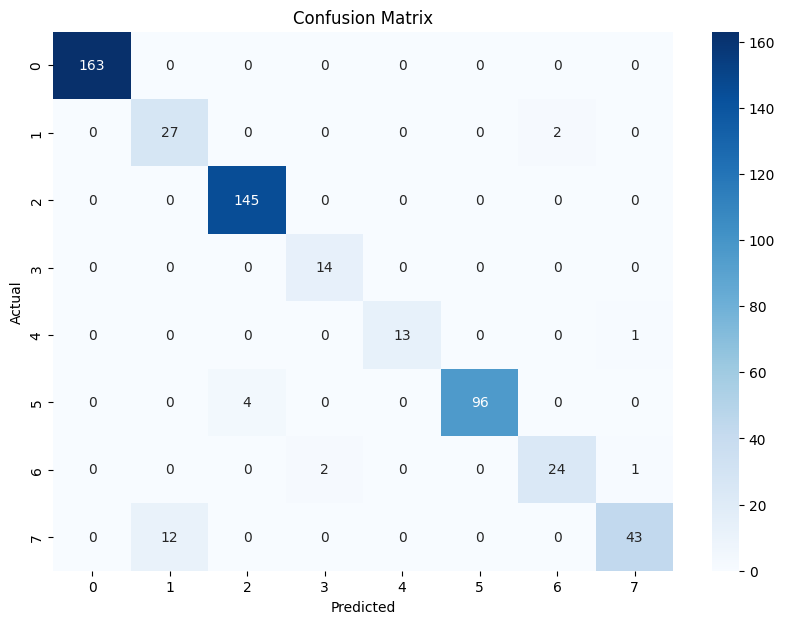

In [61]:
# Predicciones del modelo
y_pred = clf.predict(X_test)

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


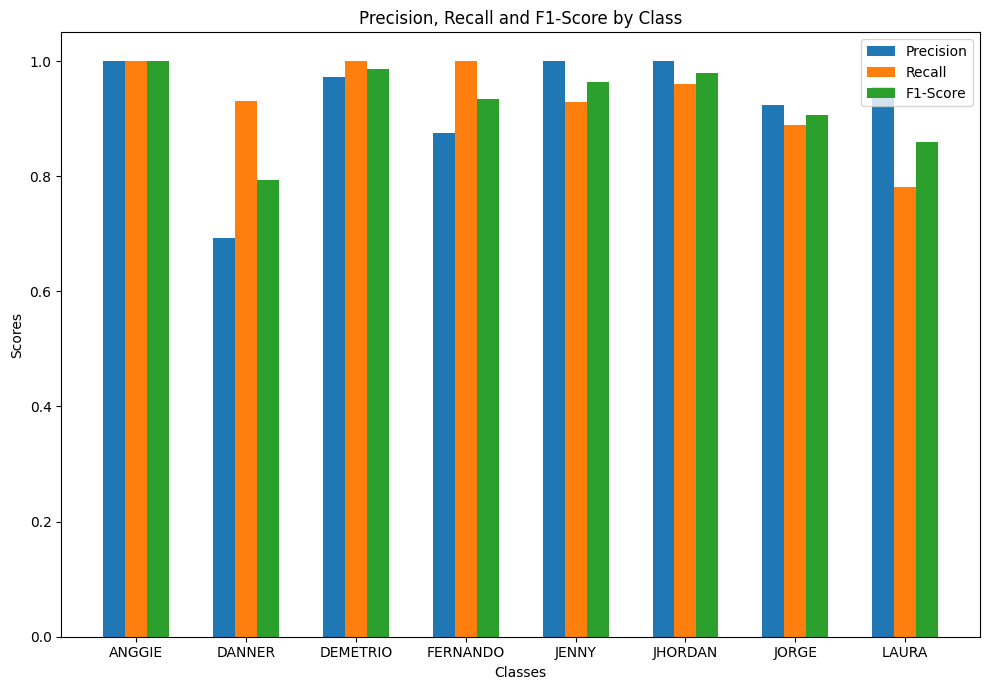

ROC AUC Score: 0.9972223756093249


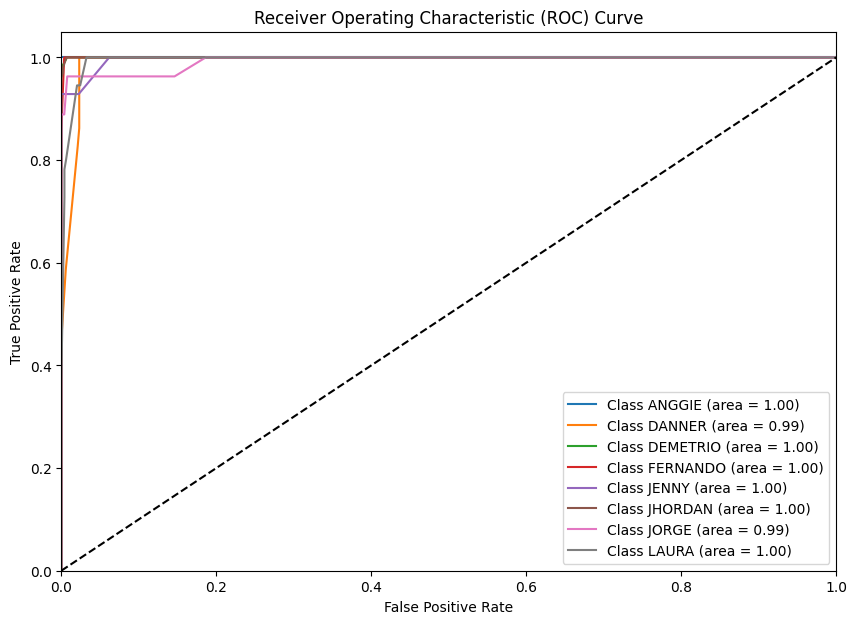

Log Loss: 0.11155553147498665


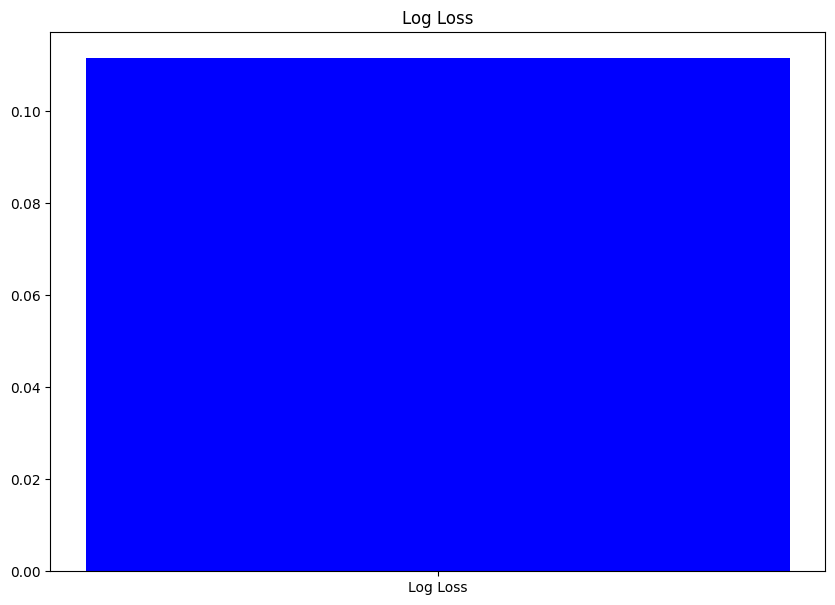

In [63]:
# Generar el reporte de clasificación con zero_division=1
report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
# Predicciones del modelo
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test) 
# Obtener las clases únicas de y_test
classes = np.unique(y_test)

# Extraer precision, recall y f1-score para cada clase
precision = [report[str(cls)]['precision'] for cls in classes]
recall = [report[str(cls)]['recall'] for cls in classes]
f1_score = [report[str(cls)]['f1-score'] for cls in classes]

# Crear gráfico de barras para precision, recall y f1-score
x = np.arange(len(precision))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

fig.tight_layout()
plt.show()

# Calcular y mostrar ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f'ROC AUC Score: {roc_auc}')

# Crear curvas ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=classes[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calcular y mostrar Log Loss
logloss = log_loss(y_test, y_prob)
print(f'Log Loss: {logloss}')

# Crear gráfico de Log Loss
plt.figure(figsize=(10, 7))
plt.bar(['Log Loss'], [logloss], color='blue')
plt.title('Log Loss')
plt.show()

C:\Users\C26764\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


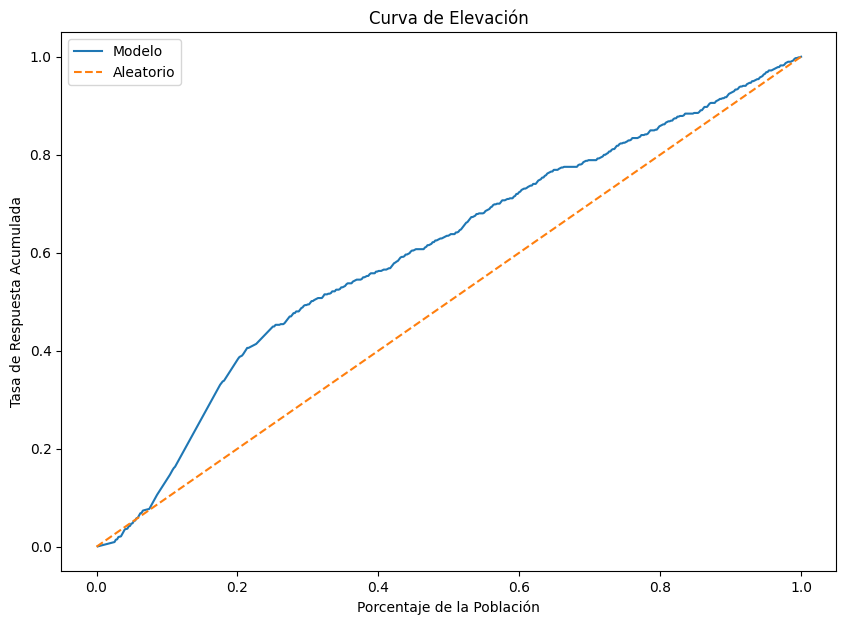

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve

# Convertir y_test a valores numéricos si es necesario
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Predicciones del modelo
y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Ordenar las instancias por probabilidad
sorted_indices = np.argsort(y_prob)[::-1]
y_test_sorted = y_test_encoded[sorted_indices]
y_prob_sorted = y_prob[sorted_indices]

# Calcular la tasa de respuesta acumulada
cumulative_gains = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
percentiles = np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted)

# Graficar la curva de elevación
plt.figure(figsize=(10, 7))
plt.plot(percentiles, cumulative_gains, label='Modelo')
plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatorio')
plt.xlabel('Porcentaje de la Población')
plt.ylabel('Tasa de Respuesta Acumulada')
plt.title('Curva de Elevación')
plt.legend()
plt.show()


## Test Real: 

In [90]:
df_test = pd.read_excel(r'C:\Users\C26764\America Movil Peru S.A.C\EAS - 1\EAUPDATE04.12.xlsx',sheet_name='Sheet1')

In [91]:
len(df_test)

531

In [92]:
random.seed(15)
lista = random.sample(range(1, 531), 15)
df_test_cut = df_test.loc[lista]
df_test_cut['RESPONSABLE_DE_EA'].tolist()

['DANNER',
 'DEMETRIO',
 'ANGGIE',
 'ANGGIE',
 'JORGE',
 'JHORDAN',
 'DEMETRIO',
 'JHORDAN',
 'DEMETRIO',
 'JORGE',
 'DEMETRIO',
 'DEMETRIO',
 'DEMETRIO',
 'JHORDAN',
 'DEMETRIO']

In [95]:
df_x = df_test_cut.drop('RESPONSABLE_DE_EA',axis=1)

In [96]:
list_predic = clf.predict(df_x).tolist()

In [97]:
list_predic

['DANNER',
 'DEMETRIO',
 'ANGGIE',
 'ANGGIE',
 'JORGE',
 'JHORDAN',
 'DEMETRIO',
 'JHORDAN',
 'DEMETRIO',
 'JORGE',
 'DEMETRIO',
 'DEMETRIO',
 'DEMETRIO',
 'DEMETRIO',
 'DEMETRIO']

In [98]:
with open(r'\\LIMBIPBICOV01.claro.pe\Red Región Norte\EAS\model_v2.pkl', 'wb') as f:
    # Usar pickle.dump para serializar y guardar el objeto
    pickle.dump(clf, f)  